In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FuncFormatter
import meep as mp

Using MPI version 4.1, 1 processes


The following code was written by Lawson Fuller, with some usage of GPT-4.

## Units in MEEP:

https://meep.readthedocs.io/en/latest/Introduction/#units-in-meep

$c = 1$

$a$ = distance = units $\mu m$

$f = \frac{c=1}{\lambda}$ (units a) = $\frac{1}{1.55}$ for 1.55 $\mu m$ light

## Define Materials:
Define the optical properties of titanium dioxide (TiO$_2$) and glass. MEEP uses relative permittivity (epsilon) to define material properties:

In [2]:
TiO2 = mp.Medium(index=2.7)  # Example index, adjust based on actual data
glass = mp.Medium(index=1.5)

## Geometry Setup:
Define the geometry of your unit cell. Assume dimensions as needed or based on the project details:

In [3]:
#  Choose dimensions that are multiple times larger than the wavelength to simulate periodicity correctly. For instance, 
# if simulating a single unit cell, you might choose sizes around a few micrometers, say 2μm.
x_size = 2.0 # micrometers
y_size = 6.0 # micrometers
z_size = 10.0 # micrometers

# size based on this paper:
# https://www.nature.com/articles/s41598-019-43588-7#:~:text=Optical%20metamaterials%20based%20on%20the,new%20generation%20of%20solar%20cells.

# Material thicknesses
tio2_ridge_height = 3.0 # micrometers
tio2_ridge_thickness = 0.1  # micrometers (100 nm)
tio2_base_thickness = 1.0  # micrometers (100 nm)
glass_base_thickness = 1.0  # micrometers (1000 nm)

# horizontal widths:
tio2_ridge_y_width = 1.0  # micrometers (1000 nm)

material_z_offset = -2.0

cell_size = mp.Vector3(0, y_size, z_size)  # Define the cell size
geometry = [mp.Block(material=TiO2,
                     center=mp.Vector3(0, 0, glass_base_thickness + tio2_base_thickness + tio2_ridge_height/2 + material_z_offset),
                     size=mp.Vector3(mp.inf, tio2_ridge_y_width, tio2_ridge_height)),
            mp.Block(material=TiO2,
                     center=mp.Vector3(0, 0, glass_base_thickness + tio2_base_thickness/2 + material_z_offset),
                     size=mp.Vector3(mp.inf, mp.inf, tio2_base_thickness)),
            mp.Block(material=glass,
                     center=mp.Vector3(0, 0, glass_base_thickness/2 + material_z_offset),
                     size=mp.Vector3(mp.inf, mp.inf, glass_base_thickness))]

In [4]:
# Define the formatter function
def format_func(value, tick_number):
    labels = {0: 'Vacuum', 1: 'Glass', 2: 'TiO2'}
    return labels.get(value, '')

def material_map(geometry, y_range, z_range, resolution):
    # Initialize the material map with 0 (vacuum)
    y_points = np.linspace(y_range[0], y_range[1], resolution)
    z_points = np.linspace(z_range[0], z_range[1], resolution)
    map_matrix = np.zeros((len(z_points), len(y_points)))
    
    # Iterate over each point in the y-z plane
    for i, z in enumerate(z_points):
        for j, y in enumerate(y_points):
            # Check each block in the geometry
            for block in geometry:
                # Get the material type
                if block.material == TiO2:
                    material_type = 2
                elif block.material == glass:
                    material_type = 1
                else:
                    continue
                
                # Determine the bounds of the block in the y and z dimensions
                y_min = block.center.y - block.size.y/2
                y_max = block.center.y + block.size.y/2
                z_min = block.center.z - block.size.z/2
                z_max = block.center.z + block.size.z/2
                
                # Check if the current point (y, z) is within this block
                if y_min <= y <= y_max and z_min <= z <= z_max:
                    map_matrix[i, j] = material_type
                    break  # Stop checking other blocks if a match is found
    
    return map_matrix

# Define the range for y and z to be visualized and the resolution of the grid
pml_thickness = 1.0 # thickness of perfectly matched layer to absorb outgoing waves
y_range = (-y_size/2, y_size/2)  # Adjust as needed
z_range = (-z_size/2, z_size/2+pml_thickness)  # Adjust as needed
resolution = 100

# Generate the material map
map_matrix = material_map(geometry, y_range, z_range, resolution)

## Visualize Materials

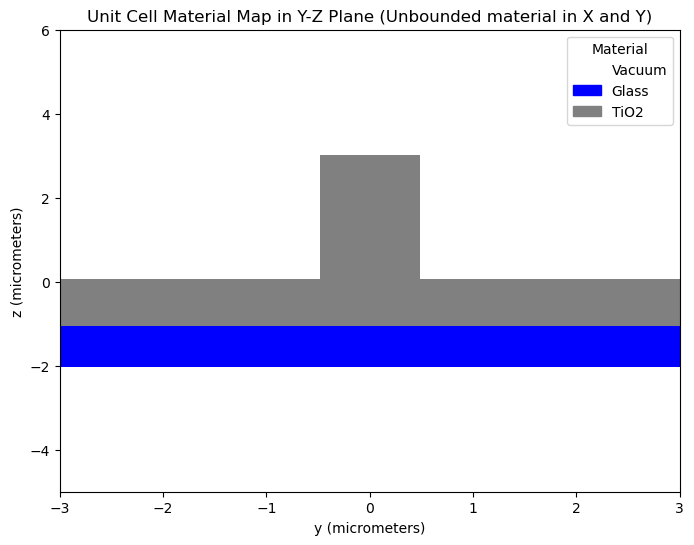

In [5]:
# Optionally, you can visualize this map using matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

# Create a figure
plt.figure(figsize=(8, 6))

# Use a discrete colormap
cmap = ListedColormap(['white', 'blue', 'grey'])
norm = plt.Normalize(vmin=0, vmax=2)

# Display the image
im = plt.imshow(map_matrix, cmap=cmap, norm=norm, extent=[y_range[0], y_range[1], z_range[0], z_range[1]], origin='lower', aspect='auto')

# Create a legend
legend_labels = {0: 'Vacuum', 1: 'Glass', 2: 'TiO2'}
patches = [Patch(color=cmap(norm(i)), label=legend_labels[i]) for i in legend_labels]
plt.legend(handles=patches, title='Material')

# Set labels and title
plt.xlabel('y (micrometers)')
plt.ylabel('z (micrometers)')
plt.title('Unit Cell Material Map in Y-Z Plane (Unbounded material in X and Y)')

# Show the plot
plt.show()

## Source Definition:
Define an appropriate source, such as a plane wave

In [6]:
freq = 1/0.55 # (if light lambda= 550 nm, range 380-700nm)
amplitude = 1
sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                     amplitude = amplitude,
                     component=mp.Ex,
                     center=mp.Vector3(0,0,z_size/2-pml_thickness-0.1),
                     size=mp.Vector3(make3D*x_size, y_size, 0))]

NameError: name 'make3D' is not defined

## Boundary Conditions:
Typically, you'll use periodic boundary conditions for a unit cell:

In [ ]:
pml_layers = [mp.PML(pml_thickness)]
# boundary_layers = [mp.PeriodicBoundary(mp.Vector3(1,0,0), phase_shift=0),
#                    mp.PeriodicBoundary(mp.Vector3(0,1,0), phase_shift=0)]

## Simulation Domain:
Set up the simulation domain:

In [ ]:
resolution = 40
sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    resolution = resolution,
                    boundary_layers = pml_layers,
                    sources=sources)

## Prepare a list to store the time series data

In [ ]:
# Define a point where you want to record the Ez component over time
monitor_point = mp.Vector3(0, 0, z_size/2)

# Define a function to record the Ez component at each time step
ex_time_series = []
ey_time_series = []
ez_time_series = []

# Define a function to record the Ez component at each time step across the YZ plane
def record_ez(sim):
    # Define the volume for the YZ plane (at x=0)
    yz_plane = mp.Volume(center=mp.Vector3(0, 0, 0), size=mp.Vector3(0, y_size, z_size))
    # Get the Ez field data across this plane
    ex_data = sim.get_array(vol=yz_plane, component=mp.Ex)
    ey_data = sim.get_array(vol=yz_plane, component=mp.Ey)
    ez_data = sim.get_array(vol=yz_plane, component=mp.Ez)
    # Append this data to the time series list
    ex_time_series.append(ex_data)
    ey_time_series.append(ey_data)
    ez_time_series.append(ez_data)

## Run the Simulation:
Execute the simulation and monitor fields:


In [ ]:
# Run the simulation with the recorder
sim.run(mp.at_every(1, record_ez), until=200)  # Adjust the interval as needed

# Convert the recorded data into a NumPy array
ex_time_series_array = np.array(ex_time_series)
ey_time_series_array = np.array(ey_time_series)
ez_time_series_array = np.array(ez_time_series)

# ez_time_series_array now contains the time series of Ez at every point in the YZ plane

In [ ]:
# ez_time_series_array

## Visualize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib


# # Draw the outlines of shapes in map_matrix
def draw_outlines(ax, map_matrix, y_size, z_size):
    y_increment = y_size / map_matrix.shape[1]
    z_increment = z_size / map_matrix.shape[0]
    print(z_increment)
    print(z_size)
    print(map_matrix.shape[0])
    bias = z_size/resolution
    for i in range(map_matrix.shape[0]):
        for j in range(map_matrix.shape[1]):
            # Draw a line above the current square if there is a material change above
            if i > 0 and map_matrix[i, j] != map_matrix[i - 1, j]:
                y_start = -y_size/2 + j * y_increment
                y_end = -y_size/2 + (j+1) * y_increment
                z_pos = -z_size/2 + i * z_increment + bias
                ax.plot([y_start, y_end], [z_pos, z_pos], 'k-', linewidth=0.5)

            # Draw a line below the current square if there is a material change below
            if i < map_matrix.shape[0] - 1 and map_matrix[i, j] != map_matrix[i + 1, j]:
                y_start = -y_size/2 + j * y_increment
                y_end = -y_size/2 + (j+1) * y_increment
                z_pos = -z_size/2 + (i + 1) * z_increment + bias
                ax.plot([y_start, y_end], [z_pos, z_pos], 'k-', linewidth=0.5)

            # Draw a line to the left of the current square if there is a material change to the left
            if j > 0 and map_matrix[i, j] != map_matrix[i, j - 1]:
                y_pos = -y_size/2 + j * y_increment
                z_start = -z_size/2 + i * z_increment + bias
                z_end = -z_size/2 + (i + 1) * z_increment + bias
                ax.plot([y_pos, y_pos], [z_start, z_end], 'k-', linewidth=0.5)

            # Draw a line to the right of the current square if there is a material change to the right
            if j < map_matrix.shape[1] - 1 and map_matrix[i, j] != map_matrix[i, j + 1]:
                y_pos = -y_size/2 + (j + 1) * y_increment
                z_start = -z_size/2 + i * z_increment + bias
                z_end = -z_size/2 + (i + 1) * z_increment + bias
                ax.plot([y_pos, y_pos], [z_start, z_end], 'k-', linewidth=0.5)

def plot_dots_for_matrix(map_matrix, y_size, z_size):
    # Calculate the increment for each cell in y and z directions
    y_increment = y_size / map_matrix.shape[1]
    z_increment = z_size / map_matrix.shape[0]

    # Initialize the plot
    fig, ax = plt.subplots()
    # Draw a dot in the center of each cell
    for i in range(map_matrix.shape[0]):
        for j in range(map_matrix.shape[1]):
            y_pos = -y_size / 2 + j * y_increment + y_increment / 2
            z_pos = -z_size / 2 + i * z_increment + z_increment / 2
            ax.plot(y_pos, z_pos, 'ro')  # 'ro' plots a red dot

    # Set plot labels and title
    ax.set_xlabel('Y dimension')
    ax.set_ylabel('Z dimension')
    ax.set_title('Dot in Center of Each Cell')

    plt.show()

# Assuming ez_time_series_array is already populated with the field data
# and has shape [time_steps, y_resolution, z_resolution]

def save_anim_fields(field_component, map_matrix, y_range, z_range):
    
    if field_component == "x":
        use_time_series = ex_time_series_array
    elif field_component == "y":
        use_time_series = ey_time_series_array
    elif field_component == "z":
        use_time_series = ez_time_series_array

    title = f'E{field_component} Field Distribution over Time'

    # Initialize the plot
    fig, ax = plt.subplots()
    cax = ax.imshow(use_time_series[0].T, extent=[-y_size/2, y_size/2, -z_size/2, z_size/2], origin='lower', cmap='viridis')
    # plt.plot(use_time_series[0].T)
    plt.xlim((-y_size/2, y_size/2))
    plt.ylim((-z_size/2, z_size/2))

    fig.colorbar(cax, label=f'E{field_component} field value')

    # # Overlay the shapes outline
    # draw_outlines(ax, map_matrix, y_size, z_size)   

    # Set plot labels and title
    ax.set_xlabel('Y dimension')
    ax.set_ylabel('Z dimension')
    ax.set_title(title)
    
    # Animation function to update the plot for each frame
    
    def animate(frame):
        cax.set_data(use_time_series[frame].T)
        return cax,
    
    # Create the animation using FuncAnimation
    anim = FuncAnimation(fig, animate, frames=len(use_time_series), interval=50, blit=True)
    
    # Save the animation as an MP4 file
    plt.tight_layout()
    anim.save(f'Visualizations/e{field_component}_field_animation.mp4', writer='ffmpeg', dpi=300)
    plt.show()

save_anim_fields("x", map_matrix, y_range, z_range)
# save_anim_fields(field_component="y")
# save_anim_fields(field_component="z")

## Trial 2D: Simple Tests of 2D Simulation

In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
resolution = 20  # pixels per unit length

# Define the simulation cell
cell_size = mp.Vector3(0, 10, 10)  # Small X dimension for 2D YZ simulation

# Add PML layers
pml_layers = [mp.PML(1.0)]

# Define a source
fcen = 1.0  # Center frequency
df = 0.2    # Frequency width
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(0, 0, 0),
                     size=mp.Vector3(0, 10, 0))]

# Simulation object
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    sources=sources,
                    resolution=resolution)

# Function to plot the field
def plot_fields(sim):
    ez_data = sim.get_array(component=mp.Ez, vol=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(0,10,10)))
    plt.figure(figsize=(6, 6))
    plt.imshow(ez_data.T, interpolation='spline36', cmap='RdBu')
    plt.colorbar(label='Ez')
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('Ez field distribution')
    plt.show()

# Run the simulation with the plotting function
sim.run(mp.at_every(1, plot_fields), until=20)

# Optionally, run the simulation first and then plot the final state
sim.run(until=20)
plot_fields(sim)


In [ ]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
resolution = 50  # pixels per unit length

# Define the simulation cell
cell_size = mp.Vector3(0, 10, 10)  # Small X dimension for 2D YZ simulation

# Add PML layers
pml_layers = [mp.PML(1.0)]

# Define materials
epsilon = 6  # Dielectric constant for the block
dielectric_material = mp.Medium(epsilon=epsilon)

# Define geometry: a dielectric block
block_size = mp.Vector3(mp.inf, 2, 2)  # Size of the block in the YZ plane
block_center = mp.Vector3(0, 0, 0)  # Center of the block in the YZ plane
dielectric_block = mp.Block(material=dielectric_material,
                            size=block_size,
                            center=block_center)

# Define a source
fcen = 1.0  # Center frequency
df = 0.2    # Frequency width
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(0, 3, 0),
                     size=mp.Vector3(0, 1, 0))]

# Simulation object
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=[dielectric_block],
                    sources=sources,
                    resolution=resolution)

# Function to plot the field with y and z axes
def plot_fields(sim):
    # Get the Ez field data
    ez_data = sim.get_array(component=mp.Ez, vol=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(0,10,10)))
    
    # Get the epsilon data to overlay the block structure
    eps_data = sim.get_array(component=mp.Dielectric, vol=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(0,10,10)))
    
    # Define y and z arrays based on the cell size and resolution
    y = np.linspace(-cell_size.y / 2, cell_size.y / 2, int(cell_size.y * resolution))
    z = np.linspace(-cell_size.z / 2, cell_size.z / 2, int(cell_size.z * resolution))
    
    # Plot the Ez field distribution
    plt.figure(figsize=(6, 6))
    plt.imshow(ez_data.T, interpolation='spline36', cmap='RdBu', extent=[y[0], y[-1], z[0], z[-1]])
    plt.colorbar(label='Ez')
    
    # Overlay the block structure using the epsilon data
    plt.contour(y, z, eps_data.T, levels=[epsilon], colors='black', linewidths=1.5)
    
    plt.xlabel('Y')
    plt.ylabel('Z')
    plt.title('Ez field distribution with dielectric block')
    plt.savefig("Visualizations/Block_gaussian_source.png")
    plt.show()

# Run the simulation with the plotting function
sim.run(mp.at_every(1, plot_fields), until=50)
# Optionally, run the simulation first and then plot the final state
sim.run(until=50)
plot_fields(sim)
